In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import warnings;
warnings.filterwarnings('ignore');

### Dataset

In [2]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Himawan Putra\Documents\GitHub\Deep-Learning-Bank-Customer-Complaint-Analysis\01_prediksi\result\01_date_preprocessing_result.csv", sep=",")
df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking,Complaint_tokenized_text
0,0,purchase order day shipping amount receive pro...,1705,True,False,False,False,False,"[['purchase', 'order', 'day', 'shipping', 'amo..."
1,1,forwarded message date tue subject please inve...,904,True,False,False,False,False,"[['forwarded', 'message', 'date', 'tue', 'subj..."
2,2,forwarded message cc sent friday pdt subject f...,1230,False,False,False,False,True,"[['forwarded', 'message', 'cc', 'sent', 'frida..."
3,3,payment history missing credit report speciali...,903,False,True,False,False,False,"[['payment', 'history', 'missing', 'credit', '..."
4,4,payment history missing credit report made mis...,851,False,True,False,False,False,"[['payment', 'history', 'missing', 'credit', '..."


### Splitting Data

In [3]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(df['narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45959 unique tokens.


In [4]:
X = tokenizer.texts_to_sequences(df['narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (162411, 250)


In [5]:
y = np.argmax(df[['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']].values, axis=1)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 , random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(103942, 250) (103942,)
(32483, 250) (32483,)


### Modeling

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, Attention, MultiHeadAttention, Flatten,  Embedding, GRU, Dense, GlobalMaxPooling1D, LayerNormalization, GlobalAveragePooling1D, Add

In [9]:
#fine tuning
num_heads = 4
num_units = 64
dropout_rate = 0.4

num_units_1 = 32
num_units_2 = 16
dropout_rate = 0.1


# Model definition
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)

# First GRU layer
gru_layer1 = GRU(num_units_1, return_sequences=True)(embedding_layer)

# First MultiHeadAttention layer
attention_output1, _ = MultiHeadAttention(num_heads=num_heads, key_dim=num_units_1)(gru_layer1, gru_layer1, gru_layer1, return_attention_scores=True)
attention_output1 = Dense(num_units_1)(attention_output1)
add_layer1 = Add()([gru_layer1, attention_output1])
norm_layer1 = LayerNormalization(epsilon=1e-6)(add_layer1)

# Dropout for regularization
dropout_layer1 = Dropout(dropout_rate)(norm_layer1)

# Second GRU layer
gru_layer2 = GRU(num_units_2, return_sequences=True)(dropout_layer1)

# Second MultiHeadAttention layer
attention_output2, _ = MultiHeadAttention(num_heads=num_heads, key_dim=num_units_2)(gru_layer2, gru_layer2, gru_layer2, return_attention_scores=True)
attention_output2 = Dense(num_units_2)(attention_output2)
add_layer2 = Add()([gru_layer2, attention_output2])
norm_layer2 = LayerNormalization(epsilon=1e-6)(add_layer2)

# Dropout for regularization
dropout_layer2 = Dropout(dropout_rate)(norm_layer2)

# Global average pooling
global_avg_pooling = GlobalAveragePooling1D()(dropout_layer2)

# Dense output layer
output_layer = Dense(5, activation='softmax')(global_avg_pooling)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 100)  │  5,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 250, 32)   │     12,864 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, 250, 32), │     16,800 │ gru[0][0],        │
│ (MultiHeadAttentio… │ (None, 4, 250,    │            │ gru[0][0],        │
│                     │ 250)]             │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 250, 32)   │      1,056 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 250, 32)   │          0 │ gru[0][0],        │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 250, 32)   │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 250, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 250, 16)   │      2,400 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, 250, 16), │      4,304 │ gru_1[0][0],      │
│ (MultiHeadAttentio… │ (None, 4, 250,    │            │ gru_1[0][0],      │
│                     │ 250)]             │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 250, 16)   │        272 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 250, 16)   │          0 │ gru_1[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 16)   │         32 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 250, 16)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ dropout_3[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │         85 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,037,877 (19.22 MB)

 Trainable params: 5,037,877 (19.22 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
num_epochs = 20
batch_size = 256
## For early stopping to ensure it doesnt overfit
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    epochs=num_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 1431s 3s/step - accuracy: 0.7129 - loss: 0.8263 - val_accuracy: 0.8721 - val_loss: 0.3727
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 1319s 3s/step - accuracy: 0.8905 - loss: 0.3194 - val_accuracy: 0.8765 - val_loss: 0.3552
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 1279s 3s/step - accuracy: 0.9137 - loss: 0.2519 - val_accuracy: 0.8762 - val_loss: 0.3636
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 1234s 3s/step - accuracy: 0.9300 - loss: 0.2079 - val_accuracy: 0.8703 - val_loss: 0.3920
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 1249s 3s/step - accuracy: 0.9405 - loss: 0.1763 - val_accuracy: 0.8730 - val_loss: 0.4075


In [13]:
# Ambil loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

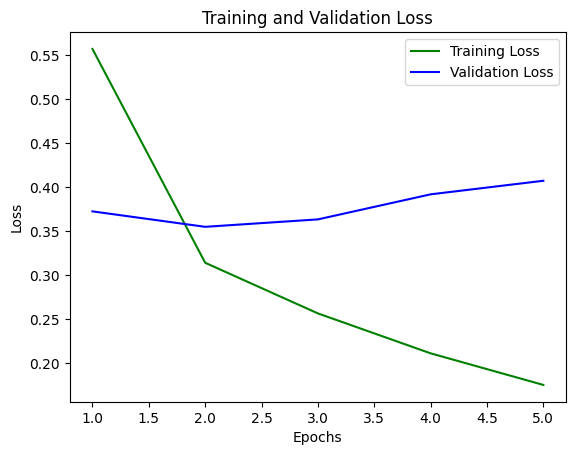

In [14]:
# Plot kurva loss
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Mengevaluasi kinerja model menggunakan data validasi
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Model Validation Accuracy:", val_acc)

813/813 ━━━━━━━━━━━━━━━━━━━━ 129s 159ms/step - accuracy: 0.8802 - loss: 0.3470
Model Validation Accuracy: 0.8765488862991333


### Evaluating the Model

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 197s 193ms/step - accuracy: 0.8785 - loss: 0.3442
Test loss: 0.3460201323032379
Test accuracy: 0.8790136575698853
